<a href="https://colab.research.google.com/github/medhatiwari/FakeNewsSpreaderDetection-SNA/blob/main/Arjun's_copy_of_SNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reading Data

In [ ]:
# importing packages
import random
import os
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd

# Reading in English meta data (spreader or not)
r = open('data/en/truth.txt', "r")
data = r.read().split("\n")
idk = [] #id
spreader = [] #yes or no

for line in data:
    l = line.split(":::")
    if len(l)>1:
        idk.append(l[0])
        spreader.append(l[1])

meta_data=pd.DataFrame()
meta_data["ID"]=idk
meta_data["spreader"]=spreader

# Reading in and concatenating English tweets

pathlist = Path('data/en').glob('**/*.xml')
ids=[]
x_raw=[]
for path in pathlist:  #iterate files
    head, tail = os.path.split(path)
    t=tail.split(".")
    author=t[0]
    ids.append(author)
    path_in_str = str(path)
    tree = ET.parse(path_in_str)
    root = tree.getroot()
    for child in root:
        xi=[]
        for ch in child:
            xi.append(ch.text)
        content = ' '.join(xi)
        x_raw.append(content)

text_data=pd.DataFrame()
text_data["ID"]=ids
text_data["Tweets"]=x_raw

# Merging meta data and text data to one dataframe
en_data = pd.merge(meta_data, text_data, how='inner', on = 'ID')
en_data.to_csv('data/en_data.tsv', sep='\t', index=False)

In [ ]:
print(en_data.head())

                                 ID spreader  \
0  4kgofb9pvi5pyjxjzjrplrgqj99njn2c        0   
1  1jjc4qfpeeffirv6pnq9aulrlk2fgl3k        1   
2  ur6ur61c96tkp8r4v5og5wo9r32ctlcc        0   
3  3efm6gac2ippn5rd7hq3cqfh6194oqmz        1   
4  gnubge5he0scnti43c95ylppja5hyu3e        1   

                                              Tweets  
0  RT #USER#: People don’t think La Liga players ...  
1  Scientists just discovered that an asteroid ma...  
2  This global framework recognises the skills an...  
3  Joe Biden Wants To Destroy Free Speech on Soci...  
4  LATE SHOW ME MORE: Happy Valentine’s Day! #URL...  


#Cleaning Data/Extracting features

In [ ]:
# !pip uninstall emoji
!pip install emoji==1.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import pandas as pd
from emoji import UNICODE_EMOJI

en_data=pd.read_csv('data/en_data.tsv',delimiter='\t', encoding='utf-8')
feed_list=en_data["Tweets"].tolist()
def cleaning_v1(tweet_lista):
    cleaned_feed_v1=[]
    for feed in tweet_lista:
        feed = feed.lower()
        feed = re.sub('[^0-9a-z #@]', "", feed)
        feed = re.sub('[\n]', " ", feed)
        cleaned_feed_v1.append(feed)
    return cleaned_feed_v1

en_data["Tweets"]=cleaning_v1(feed_list)
en_data.to_csv('data/clean_en_data_v1.tsv', sep='\t', index=False)

def is_emoji(s):
    return s in UNICODE_EMOJI
def emoji_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

def cleaning_v2(tweet_lista):
    cleaned_feed_v2=[]
    for feed in tweet_lista:
        feed = feed.lower()
        feed = emoji_space(feed)
        feed = re.sub('[,.\'\"\‘\’\”\“]', '', feed)
        feed = re.sub(r'([a-z\'-\’]+)', r'\1 ', feed)
        feed = re.sub(r'(?<![?!:;/])([:\'\";.,?()/!])(?= )','',feed)
        feed = re.sub('[\n]', ' ', feed)
        feed = ' '.join(feed.split())
        cleaned_feed_v2.append(feed)
    return cleaned_feed_v2

en_data["Tweets"]=cleaning_v2(feed_list)
en_data.to_csv('data/clean_en_data_v2.tsv', sep='\t', index=False)

#Modelling
*Testing four different learning methods with 5-fold cross-validation and grid-search for hyper-parameters*


1.   Logistic Regression
2.   Random forest
3.   SVM
4.   XGBoost



#####Logistic Regression 

In [ ]:
# Cross-validating logistic regression

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time


data_v1=pd.read_csv('data/clean_en_data_v1.tsv',delimiter='\t', encoding='utf-8')
data_v2=pd.read_csv('data/clean_en_data_v2.tsv',delimiter='\t', encoding='utf-8')


# as pipeline
# tfidf-v1
pipeline = Pipeline([('vect', TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True)),
                ('lr', LogisticRegression(penalty='l2', solver='liblinear',verbose=0, random_state=5))])
parameters={"vect__ngram_range": [(1,1),(1,2),(2,2)],
            "vect__min_df":[3,4,5,6,7,8,9,10],
            "lr__C":[.1,1,10,100,1000]}
grid_search=GridSearchCV(pipeline, parameters, cv=StratifiedKFold(5,shuffle=True, random_state=0),n_jobs=-1)
print(time.strftime("%m/%d/%Y %H:%M:%S"))
lr_tfidf_v1=grid_search.fit(data_v1["Tweets"],data_v1['spreader'])
print(time.strftime("%m/%d/%Y %H:%M:%S"))
filename='data/normalized_v1_gs.pickle' #saving out gridsearch
pickle.dump(lr_tfidf_v1, open(filename, 'wb'))
v1_df=pd.DataFrame()
v1_df['params']=lr_tfidf_v1.cv_results_['params']
v1_df['scores']=lr_tfidf_v1.cv_results_['mean_test_score']
v1_df.to_csv('data/lr_tfidf_results_v1.tsv', sep='\t', index=False)

#tfidf-v2
pipeline = Pipeline([('vect', TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True, token_pattern=r'[^\s]+')),
                ('lr', LogisticRegression(penalty='l2', solver='liblinear',verbose=0, random_state=5))])
parameters={"vect__ngram_range": [(1,1),(1,2),(2,2)],
            "vect__min_df":[3,4,5,6,7,8,9,10],
            "lr__C":[.1,1,10,100,1000]}
grid_search=GridSearchCV(pipeline, parameters, cv=StratifiedKFold(5,shuffle=True, random_state=0),n_jobs=-1)
print(time.strftime("%m/%d/%Y %H:%M:%S"))
lr_tfidf_v1=grid_search.fit(data_v2["Tweets"],data_v2['spreader'])
print(time.strftime("%m/%d/%Y %H:%M:%S"))
filename='data/normalized_v2_gs.pickle'
pickle.dump(lr_tfidf_v1, open(filename, 'wb'))
v2_df=pd.DataFrame()
v2_df['params']=lr_tfidf_v1.cv_results_['params']
v2_df['scores']=lr_tfidf_v1.cv_results_['mean_test_score']
v2_df.to_csv('data/lr_tfidf_results_v2.tsv', sep='\t', index=False)

05/04/2023 10:49:38
05/04/2023 10:56:07
05/04/2023 10:56:07
05/04/2023 11:03:10


In [ ]:
import pandas as pd
import numpy as np

frme=pd.read_csv('data/lr_tfidf_results_v1.tsv', delimiter='\t')
frme = frme.sort_values(['scores'], ascending=False)
score=np.array(frme['scores'])


for x in frme.loc[frme['scores']==np.max(score)]['params']:
    print(x)
print(np.max(score))

frme=pd.read_csv('data/lr_tfidf_results_v2.tsv', delimiter='\t')
frme = frme.sort_values(['scores'], ascending=False)
score=np.array(frme['scores'])


for x in frme.loc[frme['scores']==np.max(score)]['params']:
    print(x)
print(np.max(score))

{'lr__C': 1000, 'vect__min_df': 6, 'vect__ngram_range': (1, 2)}
0.76
{'lr__C': 100, 'vect__min_df': 9, 'vect__ngram_range': (1, 2)}
0.7566666666666666


#####Random Forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import time

data_v1=pd.read_csv('data/clean_en_data_v1.tsv',delimiter='\t', encoding='utf-8')
data_v2=pd.read_csv('data/clean_en_data_v2.tsv',delimiter='\t', encoding='utf-8')

grid=ParameterGrid({"min_max":[(1,1), (1,2), (2,2)],
                    "min_freq": [3,4,5,6,7,8,9,10],
                    "B":[100,300,400],
                    "min_n":[5,6,7,8,9,10]})

rf_results_v1=pd.DataFrame()
params_list=[]
[params_list.append(params) for params in grid]
rf_results_v1["params"]=params_list
rf_results_1=[]
i=0
for params in grid:
    i=i+1
    min_max, min_freq, B, min_n = params['min_max'], params['min_freq'], params['B'], params['min_n']
    vectorizer=TfidfVectorizer(ngram_range=min_max,min_df=min_freq,sublinear_tf=True)
    X_vectorized=vectorizer.fit_transform(data_v1['Tweets'])
    rf_clf=RandomForestClassifier(n_estimators=B, min_samples_leaf=min_n, criterion='gini',random_state=0, oob_score=True)
    rf_clf.fit(X_vectorized, data_v1["spreader"])
    oob=rf_clf.oob_score_
    rf_results_1.append(oob)
    if i%10==0:
        print(i)
        print(time.strftime("%m/%d/%Y %H:%M:%S"))
rf_results_v1['results']=rf_results_1
rf_results_v1.to_csv('data/rf_tfidf_results_v1.tsv', sep='\t', index=False)


rf_results_v2=pd.DataFrame()
rf_results_v2["params"]=params_list
rf_results_1=[]
i=0
for params in grid:
    i=i+1
    min_max, min_freq, B, min_n = params['min_max'], params['min_freq'], params['B'], params['min_n']
    vectorizer=TfidfVectorizer(ngram_range=min_max,min_df=min_freq,sublinear_tf=True, token_pattern=r'[^\s]+')
    X_vectorized=vectorizer.fit_transform(data_v2['Tweets'])
    rf_clf=RandomForestClassifier(n_estimators=B, min_samples_leaf=min_n, criterion='gini',random_state=0, oob_score=True)
    rf_clf.fit(X_vectorized, data_v2["spreader"])
    oob=rf_clf.oob_score_
    rf_results_1.append(oob)
    if i%10==0:
        print(i)
        print(time.strftime("%m/%d/%Y %H:%M:%S"))
rf_results_v2['results']=rf_results_1

rf_results_v2.to_csv('data/rf_tfidf_results_v2.tsv', sep='\t', index=False)

10
05/05/2023 03:30:19
20
05/05/2023 03:30:31
30
05/05/2023 03:30:44
40
05/05/2023 03:30:54
50
05/05/2023 03:31:07
60
05/05/2023 03:31:16
70
05/05/2023 03:31:30
80
05/05/2023 03:31:38
90
05/05/2023 03:31:51
100
05/05/2023 03:32:01
110
05/05/2023 03:32:14
120
05/05/2023 03:32:26
130
05/05/2023 03:32:36
140
05/05/2023 03:32:48
150
05/05/2023 03:33:01
160
05/05/2023 03:33:24
170
05/05/2023 03:33:42
180
05/05/2023 03:34:03
190
05/05/2023 03:34:21
200
05/05/2023 03:34:40
210
05/05/2023 03:34:59
220
05/05/2023 03:35:16
230
05/05/2023 03:35:36
240
05/05/2023 03:35:51
250
05/05/2023 03:36:12
260
05/05/2023 03:36:29
270
05/05/2023 03:36:48
280
05/05/2023 03:37:06
290
05/05/2023 03:37:25
300
05/05/2023 03:37:49
310
05/05/2023 03:38:10
320
05/05/2023 03:38:35
330
05/05/2023 03:38:55
340
05/05/2023 03:39:20
350
05/05/2023 03:39:40
360
05/05/2023 03:40:03
370
05/05/2023 03:40:26
380
05/05/2023 03:40:48
390
05/05/2023 03:41:11
400
05/05/2023 03:41:31
410
05/05/2023 03:41:56
420
05/05/2023 03:42:15
4

In [ ]:
import pandas as pd
import numpy as np

frme=pd.read_csv('data/rf_tfidf_results_v1.tsv', delimiter='\t')
frme = frme.sort_values(['results'], ascending=False)
score=np.array(frme['results'])


for x in frme.loc[frme['results']==np.max(score)]['params']:
    print(x)
print(np.max(score))

frme=pd.read_csv('data/rf_tfidf_results_v2.tsv', delimiter='\t')
frme = frme.sort_values(['results'], ascending=False)
score=np.array(frme['results'])


for x in frme.loc[frme['results']==np.max(score)]['params']:
    print(x)
print(np.max(score))

{'B': 300, 'min_freq': 7, 'min_max': (1, 2), 'min_n': 6}
0.7566666666666667
{'B': 400, 'min_freq': 7, 'min_max': (1, 2), 'min_n': 7}
0.7533333333333333


#####Linear Support Vector Machine

In [ ]:
#Cross-validating linear support vector machine

import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

data_v1=pd.read_csv('data/clean_en_data_v1.tsv',delimiter='\t', encoding='utf-8')
data_v2=pd.read_csv('data/clean_en_data_v2.tsv',delimiter='\t', encoding='utf-8')

# tfidf-v1
pipeline = Pipeline([('vect', TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True)),
                ('svm', svm.SVC(kernel='linear',  random_state=5, verbose=False))])
parameters={"vect__ngram_range": [(1,1),(1,2),(2,2)],
            "vect__min_df":[3,4,5,6,7,8,9,10],
            "svm__C":[1,10,100,1000]}
grid_search=GridSearchCV(pipeline, parameters, cv=StratifiedKFold(5,shuffle=True, random_state=0),n_jobs=-1)
print(time.strftime("%m/%d/%Y %H:%M:%S"))
svm_tfidf_v1=grid_search.fit(data_v1["Tweets"],data_v1['spreader'])
filename='data/svm_tfidf_1_cs.pickle'
pickle.dump(svm_tfidf_v1, open(filename, 'wb'))
print(time.strftime("%m/%d/%Y %H:%M:%S"))
v1_df=pd.DataFrame()
v1_df['params']=svm_tfidf_v1.cv_results_['params']
v1_df['scores']=svm_tfidf_v1.cv_results_['mean_test_score']
v1_df.to_csv('data/svm_tfidf_results_v1.tsv', sep='\t', index=False)


# tfidf-v2
pipeline = Pipeline([('vect', TfidfVectorizer(sublinear_tf=True, token_pattern=r'[^\s]+')),
                ('svm', svm.SVC(kernel='linear',  random_state=5, verbose=False))])
parameters={"vect__ngram_range": [(1,1),(1,2),(2,2)],
            "vect__min_df":[3,4,5,6,7,8,9,10],
            "svm__C":[1,10,100,1000]}
grid_search=GridSearchCV(pipeline, parameters, cv=StratifiedKFold(5,shuffle=True, random_state=0),n_jobs=-1)
print(time.strftime("%m/%d/%Y %H:%M:%S"))
svm_tfidf_v2=grid_search.fit(data_v2["Tweets"],data_v2['spreader'])
filename='data/svm_tfidf_2_cs.pickle'
pickle.dump(svm_tfidf_v2, open(filename, 'wb'))
print(time.strftime("%m/%d/%Y %H:%M:%S"))
v2_df=pd.DataFrame()
v2_df['params']=svm_tfidf_v2.cv_results_['params']
v2_df['scores']=svm_tfidf_v2.cv_results_['mean_test_score']
v2_df.to_csv('data/svm_tfidf_results_v2.tsv', sep='\t', index=False)

05/04/2023 13:34:39
05/04/2023 13:41:40
05/04/2023 13:41:40
05/04/2023 13:49:18


In [ ]:
import pandas as pd
import numpy as np

frme=pd.read_csv('data/svm_tfidf_results_v1.tsv', delimiter='\t')
frme = frme.sort_values(['scores'], ascending=False)
score=np.array(frme['scores'])


for x in frme.loc[frme['scores']==np.max(score)]['params']:
    print(x)
print(np.max(score))

frme=pd.read_csv('data/svm_tfidf_results_v2.tsv', delimiter='\t')
frme = frme.sort_values(['scores'], ascending=False)
score=np.array(frme['scores'])


for x in frme.loc[frme['scores']==np.max(score)]['params']:
    print(x)
print(np.max(score))

{'svm__C': 10, 'vect__min_df': 6, 'vect__ngram_range': (1, 2)}
0.7633333333333333
{'svm__C': 10, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
{'svm__C': 100, 'vect__min_df': 9, 'vect__ngram_range': (1, 1)}
{'svm__C': 10, 'vect__min_df': 8, 'vect__ngram_range': (1, 2)}
{'svm__C': 10, 'vect__min_df': 9, 'vect__ngram_range': (1, 1)}
{'svm__C': 100, 'vect__min_df': 4, 'vect__ngram_range': (1, 2)}
{'svm__C': 1000, 'vect__min_df': 9, 'vect__ngram_range': (1, 1)}
{'svm__C': 100, 'vect__min_df': 3, 'vect__ngram_range': (1, 2)}
0.7433333333333334


#####XGBoost

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import time
import pickle
import xgboost as xgb

data_v1=pd.read_csv('data/clean_en_data_v1.tsv', delimiter='\t',
                      encoding='utf-8')
data_v2=pd.read_csv('data/clean_en_data_v2.tsv', delimiter='\t',
                      encoding='utf-8')

pipeline = Pipeline([('vect', TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True)),
                ('xgb', xgb.XGBClassifier(random_state=0))])

parameters={"vect__ngram_range": [(1,2)],
            "vect__min_df":[7,8,9],
            "xgb__eta":[.01,.1,.3],
            "xgb__n_estimators":[200,300],
            "xgb__max_depth": [3,4,5,6],
            "xgb__subsample": [.6,.7,.8],
            "xgb__colsample_bytree":[.5,.6,.7]}

grid_search=GridSearchCV(pipeline, parameters, cv=StratifiedKFold(5,shuffle=True, random_state=0),n_jobs=-1)
print(time.strftime("%m/%d/%Y %H:%M:%S"))
xgb_v12=grid_search.fit(data_v1["Tweets"],data_v1['spreader'])
print(time.strftime("%m/%d/%Y %H:%M:%S"))
filename='data/xgb_v11_gs.pickle' #saving out gridsearch
pickle.dump(xgb_v12, open(filename, 'wb'))
v13_df=pd.DataFrame()
v13_df['params']=xgb_v12.cv_results_['params']
v13_df['scores']=xgb_v12.cv_results_['mean_test_score']
v13_df.to_csv('data/xgb_tfidf_results_v13.tsv', sep='\t', index=False)

grid_search=GridSearchCV(pipeline, parameters, cv=StratifiedKFold(5,shuffle=True, random_state=0),n_jobs=-1)
print(time.strftime("%m/%d/%Y %H:%M:%S"))
xgb_v21=grid_search.fit(data_v2["Tweets"],data_v2['spreader'])
print(time.strftime("%m/%d/%Y %H:%M:%S"))
filename='data/xgb_v21_gs.pickle' #saving out gridsearch
pickle.dump(xgb_v21, open(filename, 'wb'))
v23_df=pd.DataFrame()
v23_df['params']=xgb_v21.cv_results_['params']
v23_df['scores']=xgb_v21.cv_results_['mean_test_score']
v23_df.to_csv('data/xgb_tfidf_results_v23.tsv', sep='\t', index=False)

# train and save best model
vect_xgb_en_v1 = TfidfVectorizer(min_df=8, ngram_range=(1,2), use_idf=True, smooth_idf=True, sublinear_tf=True)
xgb_X_v1=vect_xgb_en_v1.fit_transform(data_v1['Tweets'])
xgb_en_v1 = xgb.XGBClassifier(random_state=0, colsample_bytree= 0.6, eta= 0.01, max_depth= 6, n_estimators= 300, subsample= 0.8)
xgb_en_v1.fit(xgb_X_v1,data_v1['spreader'])
pickle.dump(vect_xgb_en_v1, open('data/vect_xgb_en_v1.pickle', 'wb'))
pickle.dump(xgb_en_v1, open('data/xgb_en_v1.sav', 'wb'))

05/04/2023 13:55:21


#Finally training the best models on the complete set

In [ ]:
!pip install lexical-diversity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import pandas as pd
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

data_v1=pd.read_csv('data/clean_en_data_v1.tsv', delimiter='\t',
                      encoding='utf-8')
data_v2=pd.read_csv('data/clean_en_data_v2.tsv', delimiter='\t',
                      encoding='utf-8')

# Fitting the models
#LR
lr_vectorizer_v1=TfidfVectorizer(ngram_range=(1,2), min_df=6, sublinear_tf=True, use_idf=True, smooth_idf=True)
lr_X_v1=lr_vectorizer_v1.fit_transform(data_v1["Tweets"])
pickle.dump(lr_vectorizer_v1, open('data/lr_vectorizer_v1.pickle', 'wb'))

# Fitting best LR
# v1 {v1, 'lr__C': 1000, 'vect__min_df': 6, 'vect__ngram_range': (1, 2)}
lr_v1=LogisticRegression(C=1000, penalty='l2', solver='liblinear', fit_intercept=False, verbose=0, random_state=5)
lr_v1.fit(lr_X_v1,data_v1['spreader'])
pickle.dump(lr_v1, open('data/lr_v1.sav', 'wb'))

# RF
rf_vectorizer_v2=TfidfVectorizer(ngram_range=(1,2), min_df=9)
rf_X_v1=rf_vectorizer_v2.fit_transform(data_v2['Tweets'])
pickle.dump(rf_vectorizer_v2, open('data/rf_vectorizer_v2.pickle', 'wb'))

# Fitting best RF
# {v2, 'B': 300 min_freq': 10 min_max': (1 2) min_n': 9}
rf_v1=RandomForestClassifier(n_estimators=300, min_samples_leaf=9, criterion='gini', random_state=0, oob_score=True)
rf_v1.fit(rf_X_v1, data_v2["spreader"])
pickle.dump(rf_v1, open('data/rf_v2.sav', 'wb'))

#SVM
svm_vectorizer_v1=TfidfVectorizer(ngram_range=(1,2), min_df=5, sublinear_tf=True, use_idf=True, smooth_idf=True)
svm_X_v1=svm_vectorizer_v1.fit_transform(data_v1["Tweets"])
pickle.dump(svm_vectorizer_v1, open('data/svm_vectorizer_v1.pickle', 'wb'))

# Fitting best SVM
# v1 {v1, 'svm__C': 100 vect__min_df': 5 vect__ngram_range': (1 2)}
svm_v1=svm.SVC(C=100, kernel='linear',  probability=True, verbose=False)
svm_v1.fit(svm_X_v1, data_v1['spreader'])
pickle.dump(svm_v1, open('data/svm_v1.sav', 'wb'))





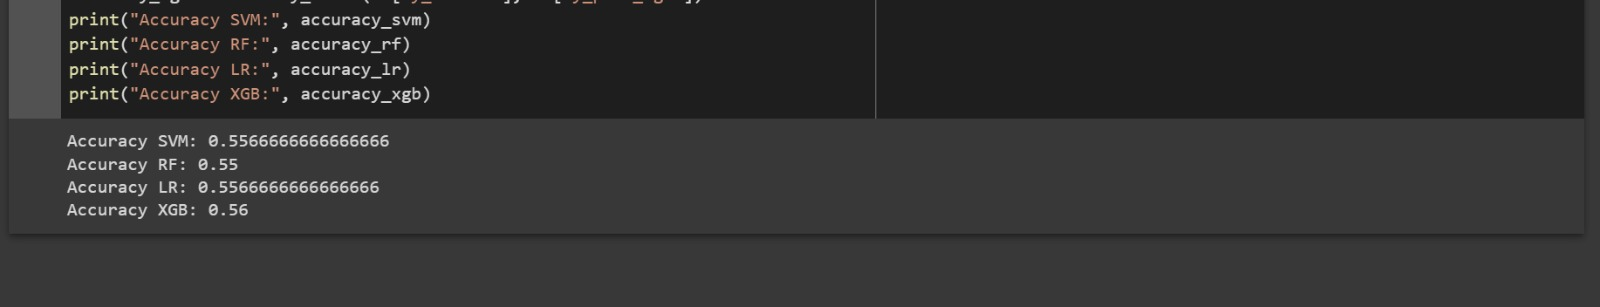

#Predicting results for the test dataset

In [ ]:
!pip install scikit-learn==0.22.2.post1

In [ ]:
#############################################
##                                         ##
##             importing packages          ##
##                                         ##
#############################################
from emoji import UNICODE_EMOJI
from html import unescape
import joblib
import math
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import random
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC


import sys
import xgboost as xgb
import xml.etree.ElementTree as ET

#############################################
##                                         ##
##    defining auxiliary  functions        ##
##                                         ##
#############################################

#text cleaning v1
def cleaning_v1(tweet_lista):
    cleaned_feed_v1=[]
    for feed in tweet_lista:
        feed = feed.lower()
        feed = re.sub('[^0-9a-z #@]', "", feed)
        feed = re.sub('[\n]', " ", feed)
        cleaned_feed_v1.append(feed)
    return cleaned_feed_v1

#emoji handling
def is_emoji(s):
    return s in UNICODE_EMOJI
def emoji_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

#text cleaning v2
def cleaning_v2(tweet_lista):
    cleaned_feed_v2=[]
    for feed in tweet_lista:
        feed = feed.lower()
        feed = emoji_space(feed)
        feed = re.sub('[,.\'\"\‘\’\”\“]', '', feed)
        feed = re.sub(r'([a-z\'-\’]+)', r'\1 ', feed)
        feed = re.sub(r'(?<![?!:;/])([:\'\";.,?()/!])(?= )','',feed)
        feed = re.sub('[\n]', ' ', feed)
        feed = ' '.join(feed.split())
        cleaned_feed_v2.append(feed)
    return cleaned_feed_v2


# dictionary for prediction
spreader={'non-spreader':0, 'spreader': 1}

###############################################
###############################################
####                                       ####
####               ENGLISH                 ####
####                                       ####
###############################################
###############################################

# read English data
pathlist = Path('data/test').glob('*.xml')
ids=[] #id list for concatenated list of tweets of each user
ids_tw = [] #id list for tweetwise list
x_test=[] #string list, 1 concatenated item per user
x_raw=[] #string list, 1 item per tweet
for path in pathlist:  #itearte files
    head, tail = os.path.split(path)
    t=tail.split(".")
    author=t[0]
    ids.append(author)
    path_in_str = str(path)
    tree = ET.parse(path_in_str)
    root = tree.getroot()
    for child in root:
        xi=[]
        for ch in child:
            xi.append(ch.text)
            x_raw.append(unescape(ch.text)) #recode xml char-s
            ids_tw.append(author)
        content = ' '.join(xi)
        x_test.append(content)

#dataframe for text cleaning v1 for n-gram models
en_data_v1=pd.DataFrame()
en_data_v1["ID"]=ids
en_data_v1["Tweets"]=x_test

#DF for text cleaning v2 for n-gram models
en_data_v2=pd.DataFrame()
en_data_v2["ID"]=ids
en_data_v2["Tweets"]=x_test

#############################################
##                                         ##
##              N-gram models              ##
##                                         ##
#############################################
# clean English data
feed_list=en_data_v1["Tweets"].tolist()
en_data_v1["Tweets"]=cleaning_v1(feed_list)
en_data_v2["Tweets"]=cleaning_v2(feed_list)

# load vectorizer
vect_rf=pickle.load(open('data/rf_vectorizer_v2.pickle',"rb"))
X_test_en_RF=vect_rf.transform(en_data_v2["Tweets"])

vect_SVM=pickle.load(open('data/svm_vectorizer_v1.pickle',"rb"))
X_test_en_SVM=vect_SVM.transform(en_data_v1["Tweets"])

vect_LR=pickle.load(open('data/lr_vectorizer_v1.pickle',"rb"))
X_test_en_LR=vect_LR.transform(en_data_v1["Tweets"])



#load model
#RF
en_RF=pickle.load(open('data/rf_v2.sav',"rb"))

#SVM
en_SVM=pickle.load(open('data/svm_v1.sav',"rb"))

#LR
en_LR=pickle.load(open('data/lr_v1.sav',"rb"))


# predicting
en_preds_RF=en_RF.predict(X_test_en_RF)

en_preds_SVM=en_SVM.predict(X_test_en_SVM)

en_preds_LR=en_LR.predict(X_test_en_LR)

#showing performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reading in English meta data (spreader or not)
r = open('data/test/en.txt', "r")
data = r.read().split("\n")
idk = [] #id
yact = [] #yes or no

for line in data:
    l = line.split(":::")
    if len(l)>1:
        idk.append(l[0])
        yact.append(int(l[1])) 
    # else:
    #     yact.append(-1)

# print(len(yact))
# print(en_preds_SVM.size)

df = pd.DataFrame()
df['y_actual'] = yact
df['y_pred_svm'] = en_preds_SVM.tolist()
df['y_pred_rf'] = en_preds_RF.tolist()
df['y_pred_lr'] = en_preds_LR.tolist()

pos_svm = 0
pos_lr = 0
pos_rf = 0
total = 0
for index, row in df.iterrows():
    total+=1;
    pos_svm+=(df['y_actual']==df['y_pred_svm'])
    pos_rf+=(df['y_actual']==df['y_pred_rf'])
    pos_lr+=(df['y_actual']==df['y_pred_lr'])

# print(df.head())

#Calculate accuracy
accuracy_svm = accuracy_score(df['y_actual'], df['y_pred_svm'])
accuracy_rf = accuracy_score(df['y_actual'], df['y_pred_rf'])
accuracy_lr = accuracy_score(df['y_actual'], df['y_pred_lr'])
print("Accuracy SVM:", accuracy_svm)
print("Accuracy RF:", accuracy_rf)
print("Accuracy LR:", accuracy_lr)
# print("Accuracy SVM:", pos_svm/total)
# print("Accuracy RF:", pos_rf/total)
# print("Accuracy LR:", pos_lr/total)

# # Calculate precision
# precision = precision_score(yact, y_pred)
# print("Precision:", precision)

# # Calculate recall
# recall = recall_score(yact, y_pred)
# print("Recall:", recall)

# # Calculate F1 score
# f1 = f1_score(yact, y_pred)
# print("F1 score:", f1)
# total = 1
# pos = 0
# for a, p in df.values.tolist():
#     total+=1
#     if a==p:
#         pos+=1

# print(pos/(total-1))

Accuracy SVM: 0.51
Accuracy RF: 0.535
Accuracy LR: 0.51


#creating a stacking ensemble for the above learning methods

###creating training and dev set for the ensemble model

In [ ]:
#########################################################
##                                                     ##
##                      importing packages             ##
##                                                     ##
#########################################################
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

#########################################################
##                                                     ##
##                       reading data                  ##
##                                                     ##
#########################################################

#loading feature DF-s
data_en_v1=pd.read_csv('data/clean_en_data_v1.tsv', delimiter='\t',
                      encoding='utf-8')
data_en_v2=pd.read_csv('data/clean_en_data_v2.tsv', delimiter='\t',
                      encoding='utf-8')

# best hyperparameters found for individual models
lr_pl=Pipeline([('vect', TfidfVectorizer(min_df=9, ngram_range=(2,2), use_idf=True, smooth_idf=True, sublinear_tf=True)),
                ('lr', LogisticRegression(C=100, penalty='l2', solver='liblinear', fit_intercept=False, verbose=0))])

rf_pl=Pipeline([('vect', TfidfVectorizer(min_df=3, ngram_range=(1,2), use_idf=True, smooth_idf=True, sublinear_tf=True)),
                ('rf', RandomForestClassifier(n_estimators=100, min_samples_leaf=8, criterion='gini'))])

svm_pl=Pipeline([('vect', TfidfVectorizer(ngram_range=(2,2), min_df=8, sublinear_tf=True, use_idf=True, smooth_idf=True)),
                ('rf', SVC(C=10, kernel='linear', verbose=False, probability=True))])

X=data_en_v1["Tweets"]
y=data_en_v1['spreader']

#########################################################
##                                                     ##
## constructing dev & train feature DF-s for ensemble  ##
##                                                     ##
#########################################################
#train set
cv = StratifiedKFold(5, shuffle=True)
results = []
for train_index, test_index in cv.split(X, y):
    preds = pd.DataFrame()
    y_train, y_test = y[train_index], y[test_index]
    preds['y_truth'] = y[test_index].values
    #LR
    X_train, X_test = data_en_v1["Tweets"][train_index], data_en_v1["Tweets"][test_index]
    lr_pl.fit(X_train,y_train)
    preds["lr"] = lr_pl.predict_proba(X_test)[:,1]

    #SVM
    X_train, X_test = data_en_v1["Tweets"][train_index], data_en_v1["Tweets"][test_index]
    svm_pl.fit(X_train,y_train)
    preds["svm"] = svm_pl.predict_proba(X_test)[:,1]

    #RF
    X_train, X_test = data_en_v1["Tweets"][train_index], data_en_v1["Tweets"][test_index]
    rf_pl.fit(X_train,y_train)
    preds["rf"] = rf_pl.predict_proba(X_test)[:,1]

    results.append(preds)

result_en=pd.concat(results)
result_en.to_csv('data/en_ensemble_train.tsv', sep='\t', index=False)

#dev set
cv = StratifiedKFold(5, shuffle=True)
results = []
for train_index, test_index in cv.split(X, y):
    preds = pd.DataFrame()
    y_train, y_test = y[train_index], y[test_index]
    preds['y_truth'] = y[test_index].values
    #LR
    X_train, X_test = data_en_v1["Tweets"][train_index], data_en_v1["Tweets"][test_index]
    lr_pl.fit(X_train,y_train)
    preds["lr"] = lr_pl.predict_proba(X_test)[:,1]

    #SVM
    X_train, X_test = data_en_v1["Tweets"][train_index], data_en_v1["Tweets"][test_index]
    svm_pl.fit(X_train,y_train)
    preds["svm"] = svm_pl.predict_proba(X_test)[:,1]

    #RF
    X_train, X_test = data_en_v1["Tweets"][train_index], data_en_v1["Tweets"][test_index]
    rf_pl.fit(X_train,y_train)
    preds["rf"] = rf_pl.predict_proba(X_test)[:,1]

    results.append(preds)
result_en_v2=pd.concat(results)
result_en_v2.to_csv('data/en_ensemble_dev.tsv', sep='\t', index=False)

###searching best stacking model

In [ ]:
#########################################################
##                                                     ##
##                      importing packages             ##
##                                                     ##
#########################################################
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline


#########################################################
##                                                     ##
##          searching best stacking model              ##
##                                                     ##
#########################################################
#load DF-s
result_en = pd.read_csv('data/en_ensemble_train.tsv', delimiter='\t',
                          encoding='utf-8')
result_en_v2 = pd.read_csv('data/en_ensemble_dev.tsv', delimiter='\t',
                          encoding='utf-8')

# MEAN
print(classification_report(result_en["y_truth"], result_en.iloc[:,1:].mean(axis=1)>0.5))
print(confusion_matrix(result_en["y_truth"], result_en.iloc[:,1:].mean(axis=1)>0.5))

print(classification_report(result_en_v2["y_truth"], result_en_v2.iloc[:,1:].mean(axis=1)>0.5))
print(confusion_matrix(result_en_v2["y_truth"], result_en_v2.iloc[:,1:].mean(axis=1)>0.5))

# MAJORITY
print(classification_report(result_en["y_truth"], (result_en.iloc[:,1:]>0.5).mean(1)>0.5))
print(confusion_matrix(result_en["y_truth"], (result_en.iloc[:,1:]>0.5).mean(1)>0.5))

print(classification_report(result_en_v2["y_truth"], (result_en_v2.iloc[:,1:]>0.5).mean(1)>0.5))
print(confusion_matrix(result_en_v2["y_truth"], (result_en_v2.iloc[:,1:]>0.5).mean(1)>0.5))

# LOGREG
acc_scorer = make_scorer(accuracy_score)
scoring = {'Accuracy': acc_scorer}
params = {'solver' : ['saga'],
        'penalty' : ['elasticnet'],
        'C' : [0, 0.1, 0.2, 0.4, 0.7, 0.9, 1, 1.2, 1.5, 2],
        'l1_ratio' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# logreg_clf = LogisticRegression()
logreg = GridSearchCV(LogisticRegression(),
                  param_grid=params,
                  scoring=scoring,
                  refit = "Accuracy",
                  return_train_score=True,
                  cv=5,
                  verbose=1,
                  n_jobs=-1
                  )

logreg.fit(result_en.iloc[:,1:], result_en["y_truth"])

#performance metrics and hyperpars
print(logreg.best_score_, logreg.best_params_, "\n",
      logreg.best_estimator_, "\n",
      logreg.best_estimator_.coef_, logreg.best_estimator_.intercept_)

print(classification_report(result_en["y_truth"],
                            logreg.predict(result_en.iloc[:,1:])))
print(confusion_matrix(result_en["y_truth"],
                            logreg.predict(result_en.iloc[:,1:])))

print(classification_report(result_en_v2["y_truth"],
                            logreg.predict(result_en_v2.iloc[:,1:])))
print(confusion_matrix(result_en_v2["y_truth"],
                            logreg.predict(result_en_v2.iloc[:,1:])))

# LINREG
params = {'alpha' : [1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 15]}
linreg_clf = RidgeClassifier()
linreg = GridSearchCV(linreg_clf,
                  param_grid=params,
                  scoring=scoring,
                  refit = "Accuracy",
                  return_train_score=True,
                  cv=5,
                  verbose=1,
                  n_jobs=-1
                  )

linreg.fit(result_en.iloc[:,1:], result_en["y_truth"])
print(linreg.best_score_, linreg.best_params_, "\n",
      linreg.best_estimator_, "\n",
      linreg.best_estimator_.coef_, linreg.best_estimator_.intercept_)

#performance metrics
print(classification_report(result_en["y_truth"],
                            linreg.predict(result_en.iloc[:,1:])))

print(classification_report(result_en_v2["y_truth"],
                            linreg.predict(result_en_v2.iloc[:,1:])))

# save out logistic regression for aggregation
joblib.dump(logreg, 'data/ensemble_en_logreg')

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       150
           1       0.66      0.63      0.65       150

    accuracy                           0.65       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.65      0.65      0.65       300

[[101  49]
 [ 55  95]]
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       150
           1       0.65      0.60      0.63       150

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300

[[102  48]
 [ 60  90]]
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       150
           1       0.66      0.63      0.65       150

    accuracy                           0.66       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.66     

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
55 fits failed out of a total of 550.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklea

0.7266666666666667 {'C': 1.5, 'l1_ratio': 1, 'penalty': 'elasticnet', 'solver': 'saga'} 
 LogisticRegression(C=1.5, l1_ratio=1, penalty='elasticnet', solver='saga') 
 [[0.22315983 0.         8.97065277]] [-4.52435982]
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       150
           1       0.75      0.69      0.72       150

    accuracy                           0.73       300
   macro avg       0.73      0.73      0.73       300
weighted avg       0.73      0.73      0.73       300

[[115  35]
 [ 47 103]]
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       150
           1       0.73      0.67      0.70       150

    accuracy                           0.71       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.71      0.71      0.71       300

[[112  38]
 [ 49 101]]
Fitting 5 folds for each of 11 candidates, totalling 55 fits
0.6966666666666665 {'

['data/ensemble_en_logreg']

###Getting the final predictions from the ensemble model

In [ ]:
#############################################
##                                         ##
##             importing packages          ##
##                                         ##
#############################################
from emoji import UNICODE_EMOJI
from html import unescape
import joblib
import math
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import random
import re
from statistics import pstdev

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import sys
import xgboost as xgb
import xml.etree.ElementTree as ET

#############################################
##                                         ##
##    defining auxiliary  functions        ##
##                                         ##
#############################################

#text cleaning v1
def cleaning_v1(tweet_lista):
    cleaned_feed_v1=[]
    for feed in tweet_lista:
        feed = feed.lower()
        feed = re.sub('[^0-9a-z #@]', "", feed)
        feed = re.sub('[\n]', " ", feed)
        cleaned_feed_v1.append(feed)
    return cleaned_feed_v1

#emoji handling
def is_emoji(s):
    return s in UNICODE_EMOJI
def emoji_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

#text cleaning v2
def cleaning_v2(tweet_lista):
    cleaned_feed_v2=[]
    for feed in tweet_lista:
        feed = feed.lower()
        feed = emoji_space(feed)
        feed = re.sub('[,.\'\"\‘\’\”\“]', '', feed)
        feed = re.sub(r'([a-z\'-\’]+)', r'\1 ', feed)
        feed = re.sub(r'(?<![?!:;/])([:\'\";.,?()/!])(?= )','',feed)
        feed = re.sub('[\n]', ' ', feed)
        feed = ' '.join(feed.split())
        cleaned_feed_v2.append(feed)
    return cleaned_feed_v2


# dictionary for prediction
spreader={'non-spreader':0, 'spreader': 1}


###############################################
###############################################
####                                       ####
####               ENGLISH                 ####
####                                       ####
###############################################
###############################################

# read English data
pathlist = Path("data/test").glob('*.xml')
ids=[] #id list for concatenated list of tweets of each user
ids_tw = [] #id list for tweetwise list
x_test=[] #string list, 1 concatenated item per user
x_raw=[] #string list, 1 item per tweet
for path in pathlist:  #itearte files
    head, tail = os.path.split(path)
    t=tail.split(".")
    author=t[0]
    ids.append(author)
    path_in_str = str(path)
    tree = ET.parse(path_in_str)
    root = tree.getroot()
    for child in root:
        xi=[]
        for ch in child:
            xi.append(ch.text)
            x_raw.append(unescape(ch.text)) #recode xml char-s
            ids_tw.append(author)
        content = ' '.join(xi)
        x_test.append(content)

#dataframe for text cleaning v1 for n-gram models
en_data_v1=pd.DataFrame()
en_data_v1["ID"]=ids
en_data_v1["Tweets"]=x_test

#DF for text cleaning v2 for n-gram models
en_data_v2=pd.DataFrame()
en_data_v2["ID"]=ids
en_data_v2["Tweets"]=x_test


#############################################
##                                         ##
##              N-gram models              ##
##                                         ##
#############################################
# clean English data
feed_list=en_data_v1["Tweets"].tolist()
en_data_v1["Tweets"]=cleaning_v1(feed_list)
en_data_v2["Tweets"]=cleaning_v2(feed_list)

# load vectorizers
vect_rf=pickle.load(open('data/rf_vectorizer_v2.pickle',"rb"))
X_test_en_RF=vect_rf.transform(en_data_v2["Tweets"])

vect_SVM=pickle.load(open('data/svm_vectorizer_v1.pickle',"rb"))
X_test_en_SVM=vect_SVM.transform(en_data_v1["Tweets"])

vect_LR=pickle.load(open('data/lr_vectorizer_v1.pickle',"rb"))
X_test_en_LR=vect_LR.transform(en_data_v1["Tweets"])


# load models
#RF
en_RF=pickle.load(open('data/rf_v2.sav',"rb"))
#SVM
en_SVM=pickle.load(open('data/svm_v1.sav',"rb"))
#LR
en_LR=pickle.load(open('data/lr_v1.sav',"rb"))


# predicting
en_preds_RF=en_RF.predict_proba(X_test_en_RF)[:, 1]
en_preds_SVM=en_SVM.predict_proba(X_test_en_SVM)[:, 1]
en_preds_LR=en_LR.predict_proba(X_test_en_LR)[:, 1]


#############################################
##                                         ##
##             stacking models             ##
##                                         ##
#############################################
results_en = pd.DataFrame()

results_en["lr"] = en_preds_LR
results_en["svm"] = en_preds_SVM
results_en["rf"] = en_preds_RF

#load model
en_ensemble = joblib.load("data/ensemble_en_logreg")
#predictions
en_preds = en_ensemble.predict(results_en)
final_pred=pd.DataFrame()
final_pred['pred']=en_preds
final_pred.to_csv('final_predictions.csv')
print(en_preds)

[1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0
 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1
 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0
 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1
 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1]


#Finall accuracy measurement

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reading in English meta data (spreader or not)
r = open('data/test/test.txt', "r")
data = r.read().split("\n")
idk = [] #id
yact = [] #yes or no

for line in data:
    l = line.split(":::")
    if len(l)>1:
        idk.append(l[0])
        yact.append(int(l[1])) 
en_preds=pd.read_csv('data/final_predictions.csv')['pred']
df = pd.DataFrame()
df['y_actual'] = yact
df['y_pred_ensem'] = en_preds.tolist()

# print(df.head())

#Calculate accuracy
accuracy_ensem = accuracy_score(df['y_actual'], df['y_pred_ensem'])
print("Accuracy for ensemble:", accuracy_ensem)

Accuracy for ensemble: 0.715
